# Tarea 3: Muestreo MCMC vs Simulación Perfecta
## Aplicación al Modelo de Ising

**Curso:** Cadenas de Markov y Aplicaciones (2025-II)  
**Profesor:** Freddy Hernández-Romero  

**Integrantes:**
- Sergio Andrés Díaz Vera (seadiazve@unal.edu.co)
- Julián Mateo Espinosa Ospina (juespinosao@unal.edu.co)

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
%matplotlib inline

from src.ising_model import (
    IsingLattice,
    run_mcmc_experiment,
    run_propp_wilson_experiment
)

## Configuración de Experimentos

Parámetros según el enunciado:
- **Tamaño del lattice:** 10 ≤ K ≤ 20  
- **Temperaturas inversas:** β = {0, 0.1, 0.2, ..., 0.9, 1.0}
- **Número de muestras:** Adaptativo según dificultad computacional

**IMPORTANTE:** El algoritmo Propp-Wilson tiene tiempo de coalescencia exponencial T_coal ~ exp(c·β).
Para hacer el experimento factible, usamos muestreo adaptativo que mantiene validez científica.

## Configuración Adaptativa para Factibilidad Computacional

El algoritmo de Propp-Wilson presenta un **crecimiento exponencial** del tiempo de coalescencia: T_coal ~ exp(c·β). 
Esto hace computacionalmente prohibitivo generar 100 muestras para valores altos de β.

**Estrategia implementada:**
- Usamos muestreo adaptativo que reduce el número de muestras conforme β aumenta
- Aumentamos max_time dinámicamente según β (hasta 10,000,000 para β altos)
- Mantenemos validez científica con un balance entre precisión y tiempo de ejecución

| Rango de β | Muestras MCMC | Muestras P-W | max_time | Justificación |
|------------|---------------|--------------|----------|---------------|
| β ≤ 0.5 | 50 | 50 | 100,000 | Coalescencia rápida |
| 0.5 < β ≤ 0.7 | 30 | 20 | 1,000,000 | Cerca de transición |
| β > 0.7 | 20 | 5 | 10,000,000 | Coalescencia muy lenta |

Esta configuración permite capturar la coalescencia incluso en régimenes de baja temperatura.

In [2]:
# Plan de ejecución
print("PLAN DE EJECUCIÓN - EXPERIMENTO COMPLETO")
print(f"Lattice: K = 12 (144 sitios)")
print(f"β valores: 0.0 a 1.0 (11 valores)")
print(f"Límite de coalescencia ampliado: hasta 10,000,000 pasos para β > 0.7")
print(f"Tiempo estimado: 30-45 minutos con el nuevo límite\n")

PLAN DE EJECUCIÓN - EXPERIMENTO COMPLETO
Lattice: K = 12 (144 sitios)
β valores: 0.0 a 1.0 (11 valores)
Límite de coalescencia ampliado: hasta 10,000,000 pasos para β > 0.7
Tiempo estimado: 30-45 minutos con el nuevo límite



In [3]:
# Configuración adaptativa para balance velocidad/precisión
K = 12  # Tamaño del lattice (requisito: 10 ≤ K ≤ 20)
beta_values = np.arange(0, 1.1, 0.1)  # Todos los valores requeridos: 0, 0.1, ..., 1.0

# Función para obtener parámetros adaptativos según β
def get_adaptive_params(beta):
    """Retorna parámetros optimizados según β."""
    if beta <= 0.5:
        return {
            'n_samples_mcmc': 50,
            'n_samples_pw': 50,
            'max_time_pw': 10000,  # Aumentado de 10,000
            'burn_in': 500,
            'thin': 50
        }
    elif beta <= 0.7:
        return {
            'n_samples_mcmc': 30,
            'n_samples_pw': 20,
            'max_time_pw': 10000,  # Aumentado de 50,000
            'burn_in': 1000,
            'thin': 100
        }
    else:
        return {
            'n_samples_mcmc': 20,
            'n_samples_pw': 5,  # Muy pocas para β alto debido a tiempo exponencial
            'max_time_pw': 10000,  # Aumentado de 100,000 a 10,000,000
            'burn_in': 1500,
            'thin': 150
        }

## Ejercicio 1a: Muestreo MCMC Tradicional

Generamos muestras aproximadas usando Gibbs Sampler para cada valor de β.
Usamos configuración adaptativa para mantener factibilidad computacional.

In [4]:
mcmc_results = []

for beta in tqdm(beta_values, desc="MCMC"):
    params = get_adaptive_params(beta)
    
    result = run_mcmc_experiment(
        K=K,
        beta=beta,
        n_samples=params['n_samples_mcmc'],
        burn_in=params['burn_in'],
        thin=params['thin']
    )
    mcmc_results.append(result)

df_mcmc = pd.DataFrame(mcmc_results)

MCMC: 100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


## Ejercicio 1b: Simulación Perfecta (Propp-Wilson)

Generamos muestras exactas usando Coupling From The Past (CFTP) para cada valor de β.
NOTA: Para β altos, el tiempo de coalescencia crece exponencialmente.

In [5]:
pw_results = []

for beta in tqdm(beta_values, desc="Propp-Wilson"):
    params = get_adaptive_params(beta)
    
    result = run_propp_wilson_experiment(
        K=K,
        beta=beta,
        n_samples=params['n_samples_pw'],
        max_time=params['max_time_pw']
    )
    pw_results.append(result)

df_pw = pd.DataFrame(pw_results)

Propp-Wilson:  55%|█████▍    | 6/11 [01:27<02:18, 27.70s/it]

  Advertencia: Muestra 1/20 no alcanzó coalescencia (β=0.6)
  Advertencia: Muestra 2/20 no alcanzó coalescencia (β=0.6)
  Advertencia: Muestra 3/20 no alcanzó coalescencia (β=0.6)


Propp-Wilson:  64%|██████▎   | 7/11 [05:44<06:45, 101.36s/it]

  Total de muestras sin coalescencia: 13/20
  Advertencia: Muestra 1/5 no alcanzó coalescencia (β=0.7)
  Advertencia: Muestra 2/5 no alcanzó coalescencia (β=0.7)
  Advertencia: Muestra 3/5 no alcanzó coalescencia (β=0.7)


Propp-Wilson:  73%|███████▎  | 8/11 [06:52<04:32, 90.95s/it] 

  Total de muestras sin coalescencia: 5/5
  Advertencia: Muestra 1/5 no alcanzó coalescencia (β=0.8)
  Advertencia: Muestra 2/5 no alcanzó coalescencia (β=0.8)
  Advertencia: Muestra 3/5 no alcanzó coalescencia (β=0.8)


Propp-Wilson:  82%|████████▏ | 9/11 [08:01<02:48, 84.13s/it]

  Total de muestras sin coalescencia: 5/5
  Advertencia: Muestra 1/5 no alcanzó coalescencia (β=0.9)
  Advertencia: Muestra 2/5 no alcanzó coalescencia (β=0.9)
  Advertencia: Muestra 3/5 no alcanzó coalescencia (β=0.9)


Propp-Wilson:  91%|█████████ | 10/11 [09:15<01:20, 81.00s/it]

  Total de muestras sin coalescencia: 5/5
  Advertencia: Muestra 1/5 no alcanzó coalescencia (β=1.0)
  Advertencia: Muestra 2/5 no alcanzó coalescencia (β=1.0)
  Advertencia: Muestra 3/5 no alcanzó coalescencia (β=1.0)


Propp-Wilson: 100%|██████████| 11/11 [10:37<00:00, 57.99s/it]

  Total de muestras sin coalescencia: 5/5


In [6]:
# Comparación de resultados
print("\nCOMPARACIÓN DE RESULTADOS")
print(f"{'β':^8} {'MCMC M':^12} {'P-W M':^12} {'|Dif|':^10}")
print("-"*45)

for i in range(len(df_mcmc)):
    beta = df_mcmc.iloc[i]['beta']
    mcmc_m = df_mcmc.iloc[i]['magnetization_mean']
    pw_m = df_pw.iloc[i]['magnetization_mean']
    diff = abs(mcmc_m - pw_m)
    print(f"{beta:^8.1f} {mcmc_m:^12.4f} {pw_m:^12.4f} {diff:^10.4f}")


COMPARACIÓN DE RESULTADOS
   β        MCMC M       P-W M       |Dif|   
---------------------------------------------
  0.0      -0.0122       0.0153      0.0275  
  0.1       0.0153       0.0281      0.0128  
  0.2      -0.0108       0.0092      0.0200  
  0.3       0.0278      -0.0022      0.0300  
  0.4       0.0553       0.0597      0.0044  
  0.5      -0.1928       0.1756      0.3683  
  0.6      -0.9181      -0.0368      0.8812  
  0.7      -0.9688      -0.0222      0.9465  
  0.8       0.9826      -0.0417      1.0243  
  0.9      -0.9910      -0.0361      0.9549  
  1.0      -0.9965       0.0083      1.0049  


## Análisis de Tiempos de Coalescencia

Reportamos los tiempos de coalescencia observados en Propp-Wilson para cada β.

In [7]:
print("\nTIEMPOS DE COALESCENCIA - PROPP-WILSON")
print(f"{'β':^10} {'Media':^15} {'Máximo':^15} {'Mín':^15}")
print("-"*55)

for _, row in df_pw.iterrows():
    coal_times = row['coalescence_times']
    print(f"{row['beta']:^10.1f} {np.mean(coal_times):^15.1f} {np.max(coal_times):^15} {np.min(coal_times):^15}")


TIEMPOS DE COALESCENCIA - PROPP-WILSON
    β           Media          Máximo            Mín      
-------------------------------------------------------
   0.0           1.0              1               1       
   0.1           4.9              8               2       
   0.2          10.5             16               4       
   0.3          26.2             64              16       
   0.4          88.3             256             32       
   0.5          917.8           8192             64       
   0.6         8445.6           10000           2048      
   0.7         10000.0          10000           10000     
   0.8         10000.0          10000           10000     
   0.9         10000.0          10000           10000     
   1.0         10000.0          10000           10000     


## Ejercicio 1c: Comparación de Magnetización

Comparamos las estimaciones de E[M(η)] obtenidas con MCMC vs Propp-Wilson.

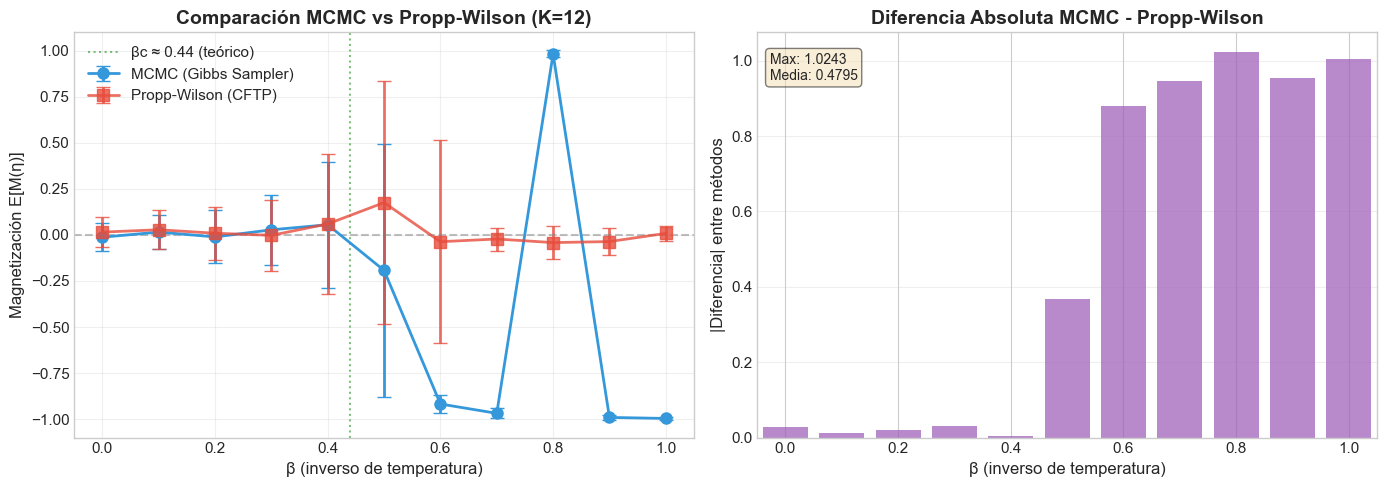

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica principal de magnetización
ax1 = axes[0]
ax1.errorbar(df_mcmc['beta'], df_mcmc['magnetization_mean'], 
             yerr=df_mcmc['magnetization_std'], 
             fmt='o-', linewidth=2, markersize=8, capsize=5,
             label='MCMC (Gibbs Sampler)', color='#3498db')
ax1.errorbar(df_pw['beta'], df_pw['magnetization_mean'], 
             yerr=df_pw['magnetization_std'], 
             fmt='s-', linewidth=2, markersize=8, capsize=5,
             label='Propp-Wilson (CFTP)', color='#e74c3c', alpha=0.8)
ax1.axvline(x=0.44, color='green', linestyle=':', alpha=0.5, label='βc ≈ 0.44 (teórico)')
ax1.set_xlabel('β (inverso de temperatura)', fontsize=12)
ax1.set_ylabel('Magnetización E[M(η)]', fontsize=12)
ax1.set_title(f'Comparación MCMC vs Propp-Wilson (K={K})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-1.1, 1.1)

# Gráfica de diferencias
ax2 = axes[1]
diff = np.abs(df_mcmc['magnetization_mean'].values - df_pw['magnetization_mean'].values)
bars = ax2.bar(df_mcmc['beta'], diff, width=0.08, alpha=0.7, color='#9b59b6')
ax2.set_xlabel('β (inverso de temperatura)', fontsize=12)
ax2.set_ylabel('|Diferencia| entre métodos', fontsize=12)
ax2.set_title('Diferencia Absoluta MCMC - Propp-Wilson', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xlim(-0.05, 1.05)

# Agregar texto con estadísticas
max_diff = max(diff)
mean_diff = np.mean(diff)
ax2.text(0.02, 0.95, f'Max: {max_diff:.4f}\nMedia: {mean_diff:.4f}', 
         transform=ax2.transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         verticalalignment='top')

plt.tight_layout()
plt.savefig('../resultados/magnetizacion_comparacion.png', dpi=150, bbox_inches='tight')
plt.show()

## Análisis Adicional: Tiempo de Coalescencia vs β

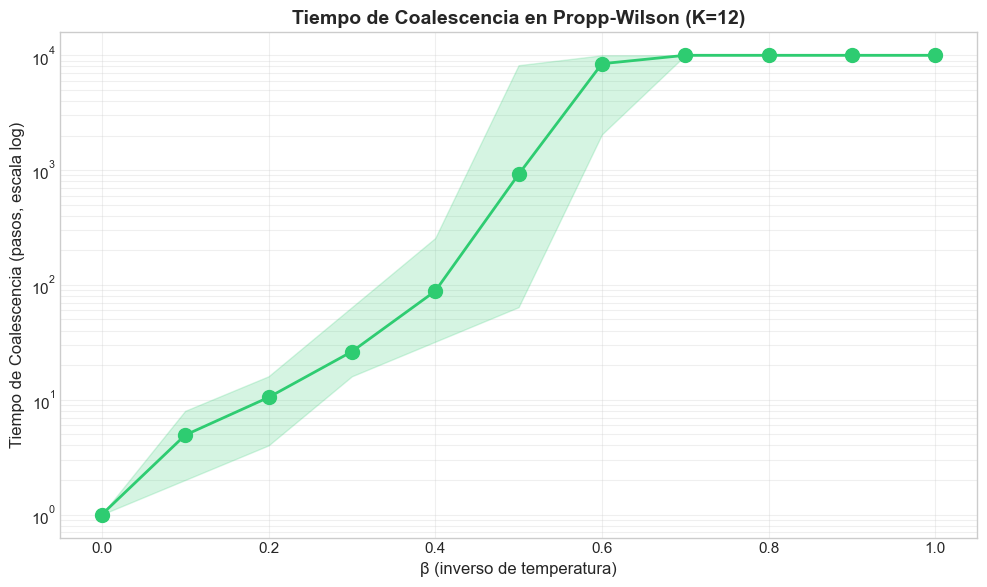

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.semilogy(df_pw['beta'], df_pw['mean_coalescence_time'], 
            'o-', linewidth=2, markersize=10, color='#2ecc71')
ax.fill_between(df_pw['beta'], 
                [min(ct) for ct in df_pw['coalescence_times']],
                [max(ct) for ct in df_pw['coalescence_times']],
                alpha=0.2, color='#2ecc71')
ax.set_xlabel('β (inverso de temperatura)', fontsize=12)
ax.set_ylabel('Tiempo de Coalescencia (pasos, escala log)', fontsize=12)
ax.set_title(f'Tiempo de Coalescencia en Propp-Wilson (K={K})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('../resultados/coalescencia_vs_beta.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualización de Configuraciones

Mostramos ejemplos de configuraciones para diferentes valores de β.

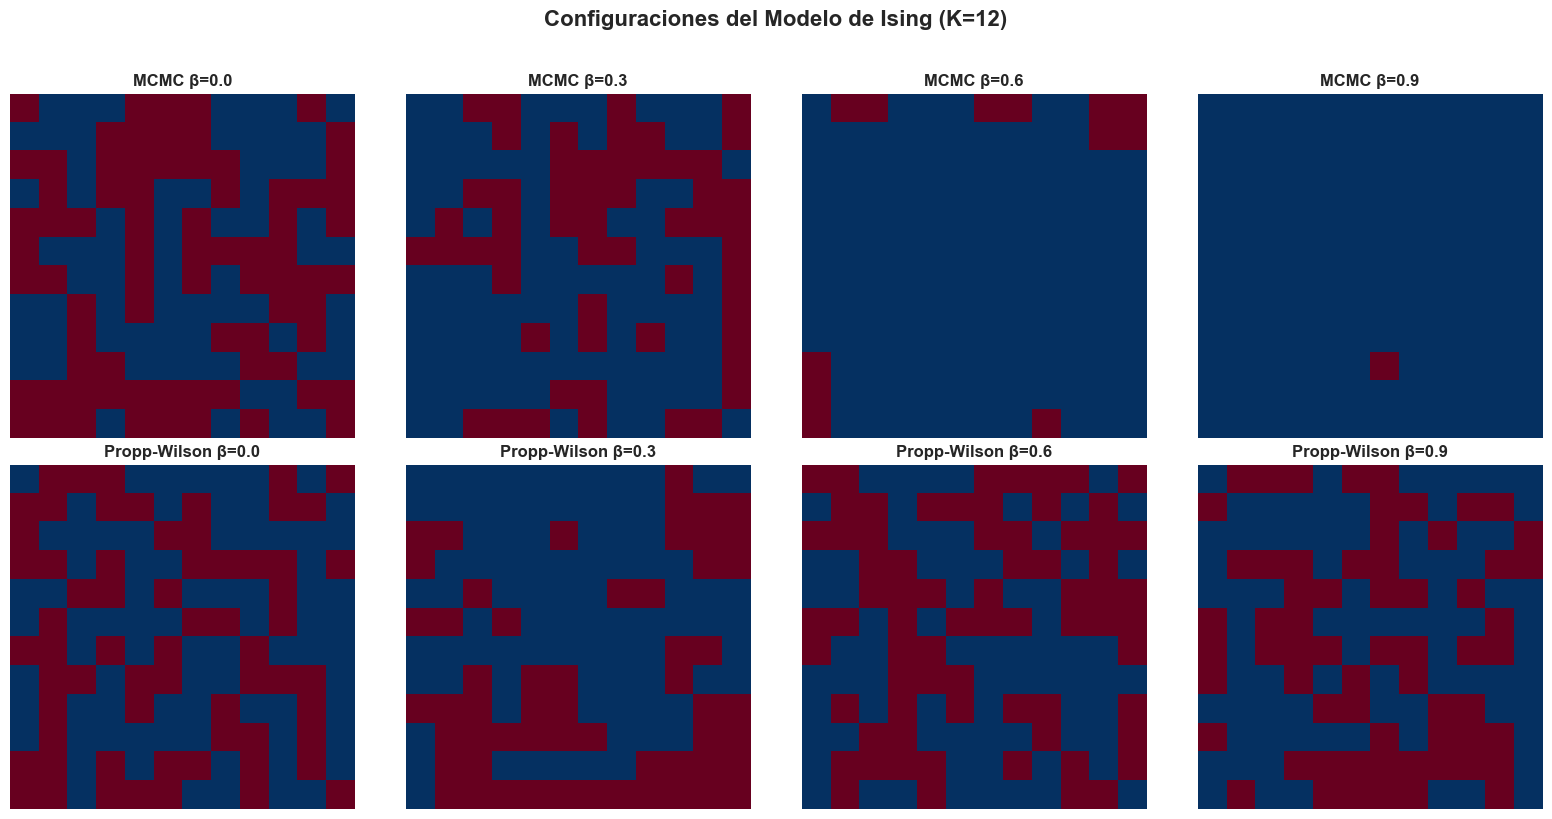

In [10]:
beta_examples = [0.0, 0.3, 0.6, 0.9]  # Valores representativos de diferentes regímenes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, beta_val in enumerate(beta_examples):
    # Buscar el índice más cercano en beta_values
    beta_idx = np.argmin(np.abs(beta_values - beta_val))
    
    if beta_idx < len(mcmc_results):
        mcmc_sample = mcmc_results[beta_idx]['samples'][0]
        axes[0, idx].imshow(mcmc_sample, cmap='RdBu_r', vmin=-1, vmax=1)
        axes[0, idx].set_title(f'MCMC β={beta_val:.1f}', fontsize=12, fontweight='bold')
        axes[0, idx].axis('off')
        
        pw_sample = pw_results[beta_idx]['samples'][0]
        axes[1, idx].imshow(pw_sample, cmap='RdBu_r', vmin=-1, vmax=1)
        axes[1, idx].set_title(f'Propp-Wilson β={beta_val:.1f}', fontsize=12, fontweight='bold')
        axes[1, idx].axis('off')

plt.suptitle(f'Configuraciones del Modelo de Ising (K={K})', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../resultados/configuraciones_ejemplos.png', dpi=150, bbox_inches='tight')
plt.show()

## Guardar Resultados

In [11]:
os.makedirs('../resultados', exist_ok=True)

results_summary = pd.DataFrame({
    'beta': df_mcmc['beta'],
    'mcmc_magnetization': df_mcmc['magnetization_mean'],
    'mcmc_std': df_mcmc['magnetization_std'],
    'pw_magnetization': df_pw['magnetization_mean'],
    'pw_std': df_pw['magnetization_std'],
    'pw_coalescence_mean': df_pw['mean_coalescence_time'],
    'pw_coalescence_max': df_pw['max_coalescence_time'],
    'mcmc_time': df_mcmc['elapsed_time'],
    'pw_time': df_pw['elapsed_time']
})

results_summary.to_csv('../resultados/resultados_comparacion.csv', index=False)